In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)

seed = 352 # set seed for reproducibility

df = pd.read_csv('SunPower_Merged.csv', sep = ',', parse_dates=['timestamp'], index_col='timestamp')

df.head()


,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
timestamp,,,,,,,
2013-07-22 00:00:00,0.000,6.700,67,0.000,0.000,10.200,0
2013-07-22 01:00:00,0.000,5.700,71,0.000,0.000,9.200,0
2013-07-22 02:00:00,0.000,4.800,76,0.000,0.000,9.100,0
2013-07-22 03:00:00,0.000,4.100,79,0.000,0.000,10.200,0
2013-07-22 04:00:00,0.000,3.400,81,0.000,0.000,10.200,0


Summary of the data

In [3]:
# Get summary statistics for the DataFrame
df.describe()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
count,83628.000,85384.000,85384.000,85384.000,85384.000,85384.000,85384.000
mean,1.241,22.681,35.087,198.305,54.703,14.497,15.648
std,1.683,8.644,21.180,283.469,72.160,5.985,24.981
min,-0.003,-0.600,3.000,0.000,0.000,0.000,0.000
25%,0.000,16.400,19.000,0.000,0.000,10.400,0.000
50%,0.000,23.000,29.000,3.000,8.000,13.800,1.000
75%,2.638,29.100,47.000,387.000,100.000,18.200,25.000
max,5.995,45.100,100.000,1024.000,520.000,50.400,100.000


Missing Values Analysis

<Figure size 1500x500 with 0 Axes>

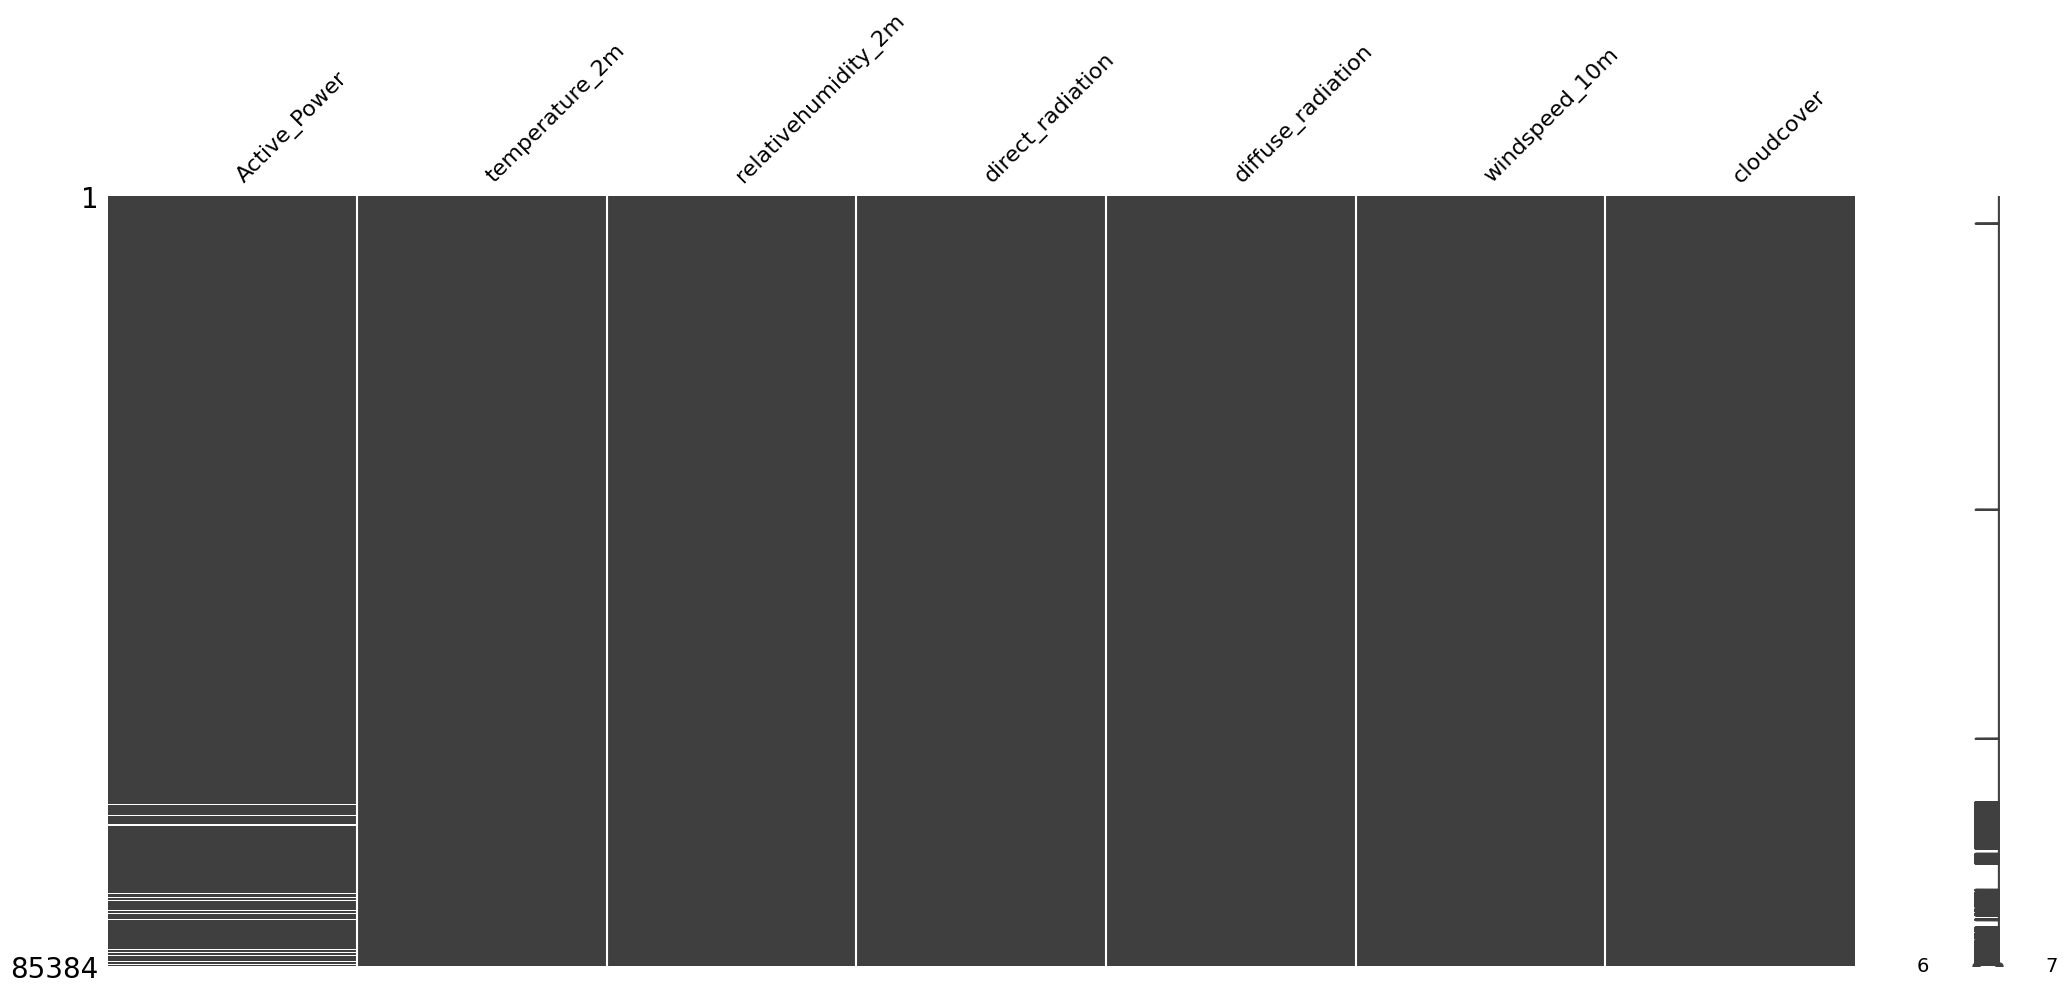

In [4]:
# Visualize missing data
plt.figure(figsize=(15, 5))
msno.matrix(df)
plt.show()


MICE imputation - KNN estimator

In [5]:
from sklearn.impute import KNNImputer

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Impute the missing values
imputed_data = imputer.fit_transform(df)

# Convert the imputed data back to DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

# Check for any remaining missing values
print(imputed_data_df.isna().sum())


Active_Power           0
temperature_2m         0
relativehumidity_2m    0
direct_radiation       0
diffuse_radiation      0
windspeed_10m          0
cloudcover             0
dtype: int64


As energy generated can't be negative for the purposes of this study, negative imputed values will be set to 0

In [8]:
# set negative values to 0 
imputed_data_df['Active_Power'] = imputed_data_df['Active_Power'].clip(lower=0)

#check
imputed_data_df[imputed_data_df['Active_Power'] < 0 ]

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
timestamp,,,,,,,


Mean and std of the feature before and after MICE imputation

In [9]:
mean_before = df['Active_Power'].mean()
std_before = df['Active_Power'].std()

print(f'Mean before MICE: {mean_before:.5f}')
print(f'Standard deviation before MICE: {std_before:.5f}')

mean_after = imputed_data_df['Active_Power'].mean()
std_after = imputed_data_df['Active_Power'].std()

print(f'Mean before MICE: {mean_after:.5f}')
print(f'Standard deviation before MICE: {std_after:.5f}')

Mean before MICE: 1.24120
Standard deviation before MICE: 1.68298
Mean before MICE: 1.24189
Standard deviation before MICE: 1.68198


Outlier Analysis

In [10]:
import pandas as pd
from scipy import stats

# Assuming df is your DataFrame with a timestamp index and numerical columns
# Drop non-numerical columns if any
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Compute Z-scores
z_scores = stats.zscore(numerical_df)
abs_z_scores = abs(z_scores)
threshold = 3  # Common threshold for identifying outliers

# Create a DataFrame with outliers identified
outliers = (abs_z_scores > threshold)

# Count of outliers
print("Number of outliers per column:")
print(pd.DataFrame(outliers, columns=numerical_df.columns).sum())

# Optionally, see outlier rows
outlier_rows = df[~(outliers.all(axis=1))]
print("Outlier rows:")
print(outlier_rows)


Number of outliers per column:
Active_Power              0
temperature_2m            0
relativehumidity_2m      57
direct_radiation          0
diffuse_radiation      1473
windspeed_10m           441
cloudcover             1902
dtype: int64
Outlier rows:
                     Active_Power  temperature_2m  relativehumidity_2m  \
timestamp                                                                
2013-07-22 00:00:00         0.000           6.700                   67   
2013-07-22 01:00:00         0.000           5.700                   71   
2013-07-22 02:00:00         0.000           4.800                   76   
2013-07-22 03:00:00         0.000           4.100                   79   
2013-07-22 04:00:00         0.000           3.400                   81   
...                           ...             ...                  ...   
2023-05-27 19:00:00         0.000          11.900                   44   
2023-05-27 20:00:00         0.000          10.700                   48   
2023-0

In [11]:
import pandas as pd

# Assuming df is your DataFrame with a timestamp index and numerical columns
# Drop non-numerical columns if any
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate IQR and identify outliers
Q1 = numerical_df.quantile(0.25)
Q3 = numerical_df.quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = (numerical_df < lower_bound) | (numerical_df > upper_bound)

# Count of outliers
print("Number of outliers per column:")
print(pd.DataFrame(outliers).sum())

# Optionally, see outlier rows
outlier_rows = df[(outliers).any(axis=1)]
print("Outlier rows:")
print(outlier_rows)


Number of outliers per column:
Active_Power              0
temperature_2m            0
relativehumidity_2m    1429
direct_radiation        224
diffuse_radiation      1932
windspeed_10m           955
cloudcover             6232
dtype: int64
Outlier rows:
                     Active_Power  temperature_2m  relativehumidity_2m  \
timestamp                                                                
2013-08-16 10:00:00         1.182          26.900                   16   
2013-08-16 11:00:00         3.009          29.200                   14   
2013-08-16 12:00:00         3.733          30.700                   14   
2013-08-16 13:00:00         4.420          31.900                   13   
2013-08-16 14:00:00         4.138          32.400                   13   
...                           ...             ...                  ...   
2023-05-06 21:00:00         0.000          16.700                   37   
2023-05-06 22:00:00         0.000          16.300                   38   
2023-0

In [13]:
def check_gaussian_distribution(dataframe, attribute, alpha, print_details = False):

	"""The purposes of this function is to check if a features' distribution follows a Gaussian distribution.
	Each test looks at the question of whether a sample was drawn from a Gaussian distribution from a slightly different perspective.
	The Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data
	The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution
	Anderson-Darling Test can be used to check whether a data sample is normal;it is a modified version of the more sophisticated nonparametric goodness-of-fit statistical test Kolmogorov-Smirnov
	A feature of the Anderson-Darling test is that it returns a list of critical values rather than a single p-value. This can provide the basis for a more thorough interpretation of the result."""
		


	from scipy.stats import shapiro
	from scipy.stats import normaltest
	from scipy.stats import anderson

	data = dataframe[attribute].values
	shapirostat, p = shapiro(data)
	k2stat, l = normaltest(data)
	result = anderson(data)

	for i in range(len(result.critical_values)):
		sl, cv = result.significance_level[i], result.critical_values[i]
	if (print_details == True):
		print("🟢🟢🟢🟢🟢 Normality Tests 🟢🟢🟢🟢🟢")
		print("H0: variable follows a Gaussian distribution\nH1: variable does not follow a Gaussian distribution" )
		print("------------------------------------------")
		print('Shapiro Statistics=%.3f, p=%.3f' % (shapirostat, p))
		if p > alpha:
			print('Shapiro test: Sample looks Gaussian (fail to reject H0)')
		else:
			print('Shapiro test: Sample does not look Gaussian (reject H0)')
		print("------------------------------------------")
		print('K^2 Statistics=%.3f, p=%.3f' % (k2stat, l))
		if l > alpha:
			print('K^2 test: Sample looks Gaussian (fail to reject H0)')
		else:
			print('K^2 test: Sample does not look Gaussian (reject H0)')
		print("------------------------------------------")
		print('Anderson-Darling Statistic: %.3f' % result.statistic)

		if result.statistic < result.critical_values[i]:
			print('%.3f: %.3f, data looks normal from an Anderson-Darling perspective (fail to reject H0)' % (sl, cv))
		else:
			print('%.3f: %.3f, data does not look normal from an Anderson-Darling perspective (reject H0)' % (sl, cv))
		print("------------------------------------------")
		if ((p>alpha) & (l> alpha) & (result.statistic < result.critical_values[i]) ):
			print("All of the normality tests conclude that the attribute " + attribute + " is extracted from a Gaussian distribution")
		
		else:
			print("At least 1 of the normality tests indicate that the attribute " + attribute + " does not follow a Gaussian distribution")
		
	
	#Critical values in a statistical test are a range of pre-defined significance boundaries at which the H0 can be failed to be rejected if
	# the calculated statistic is less than the critical value. 
	# Rather than just a single p-value, the test returns a critical value for a range of different commonly used significance levels.
	if ((p>alpha) & (l> alpha) & (result.statistic < result.critical_values[i])):
		return "Gaussian"
	else:
		return "Not Gaussian"

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column Active_Power: 0


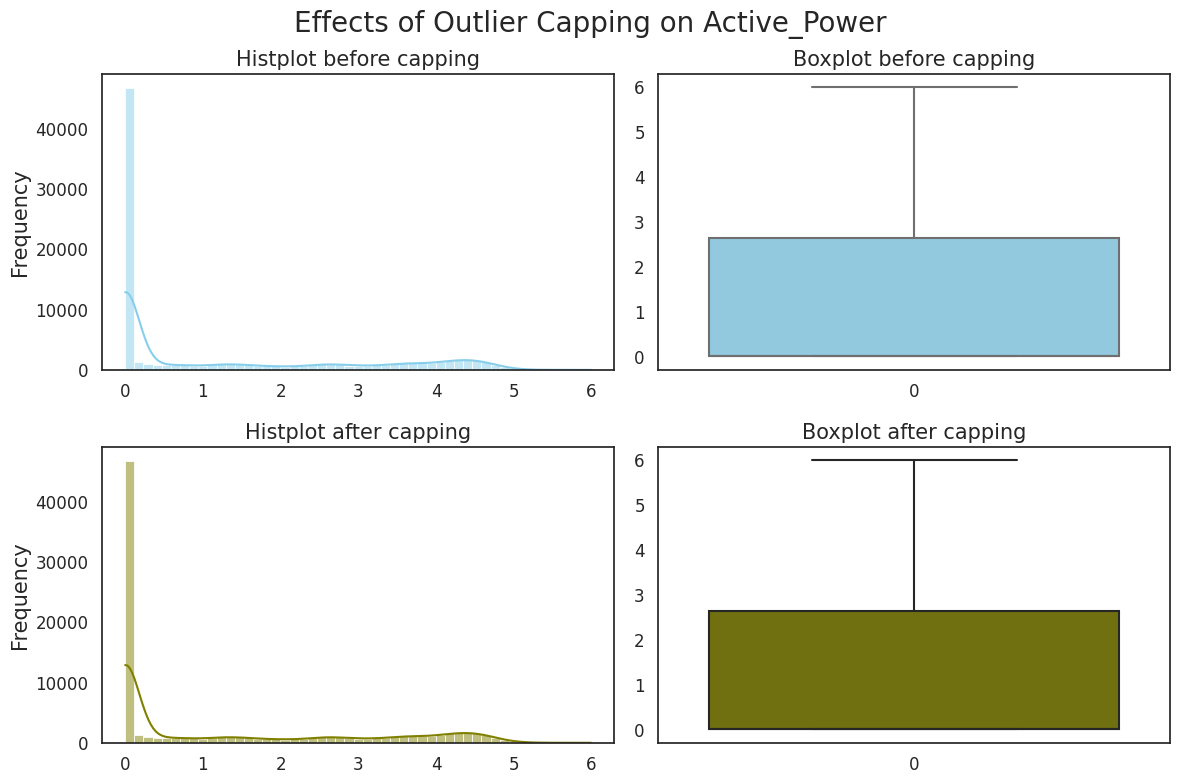

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column temperature_2m: 0


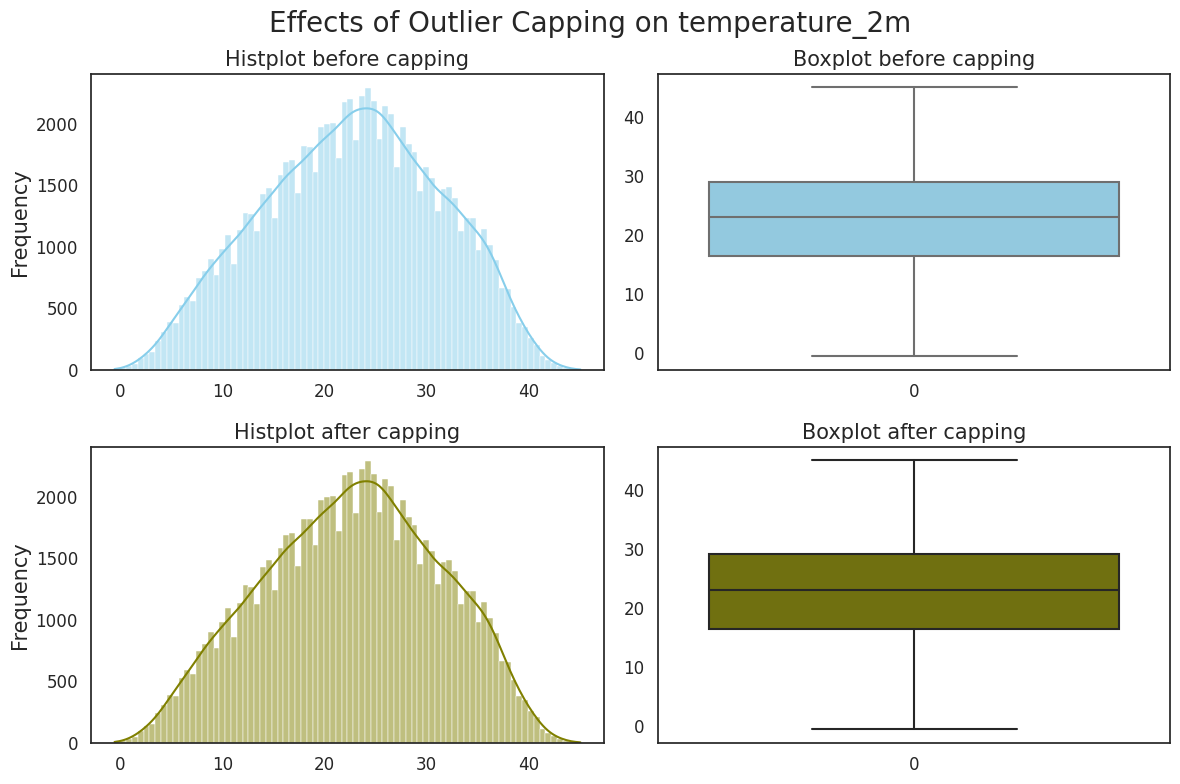

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column relativehumidity_2m: 1429


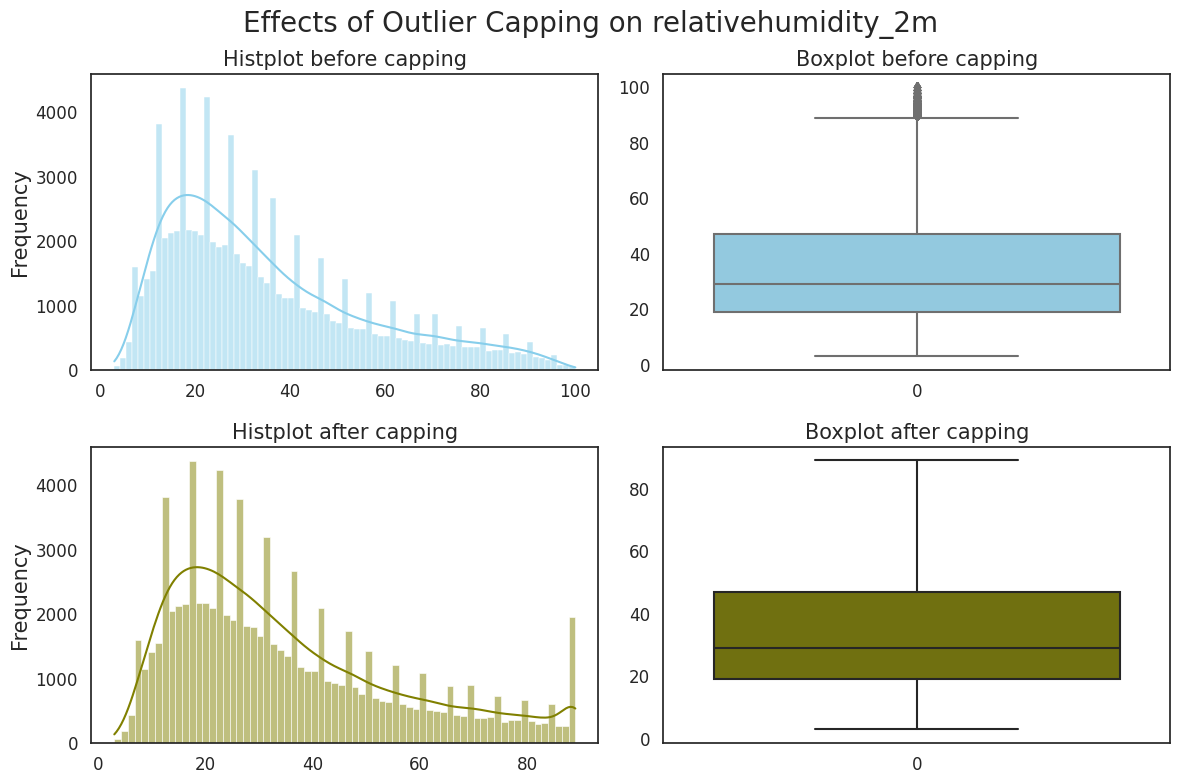

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column direct_radiation: 224


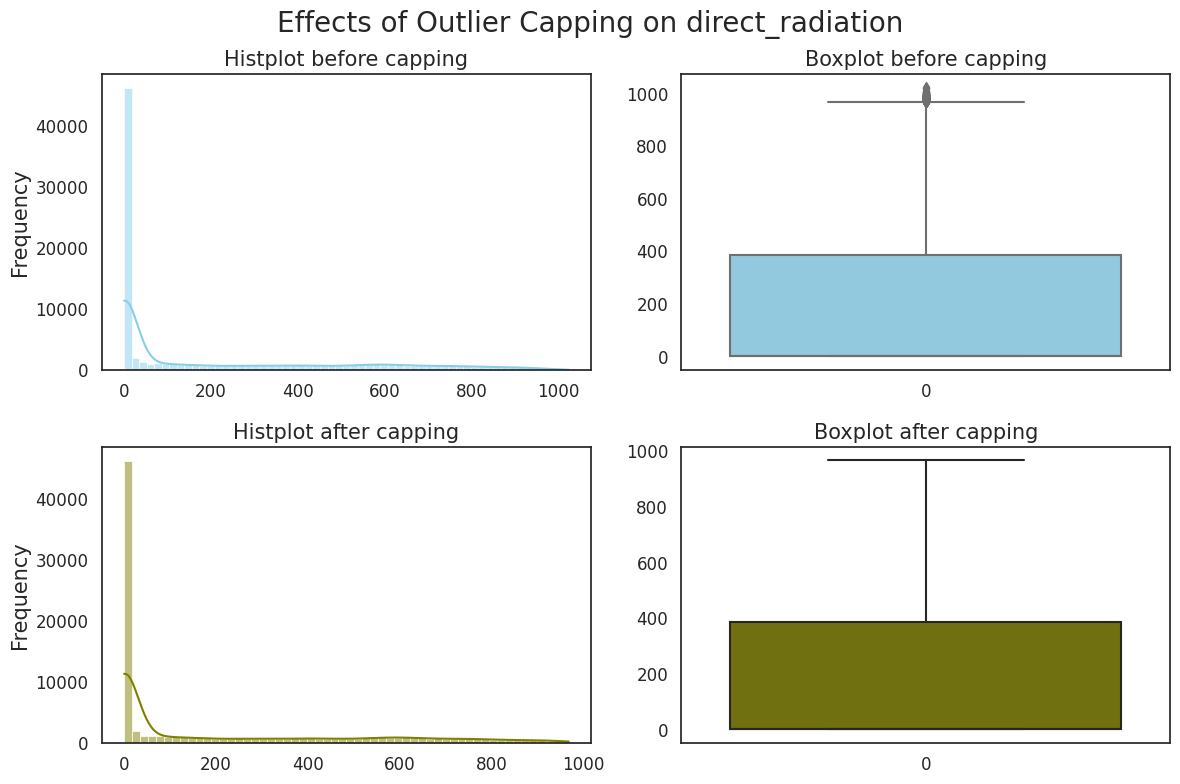

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column diffuse_radiation: 1932


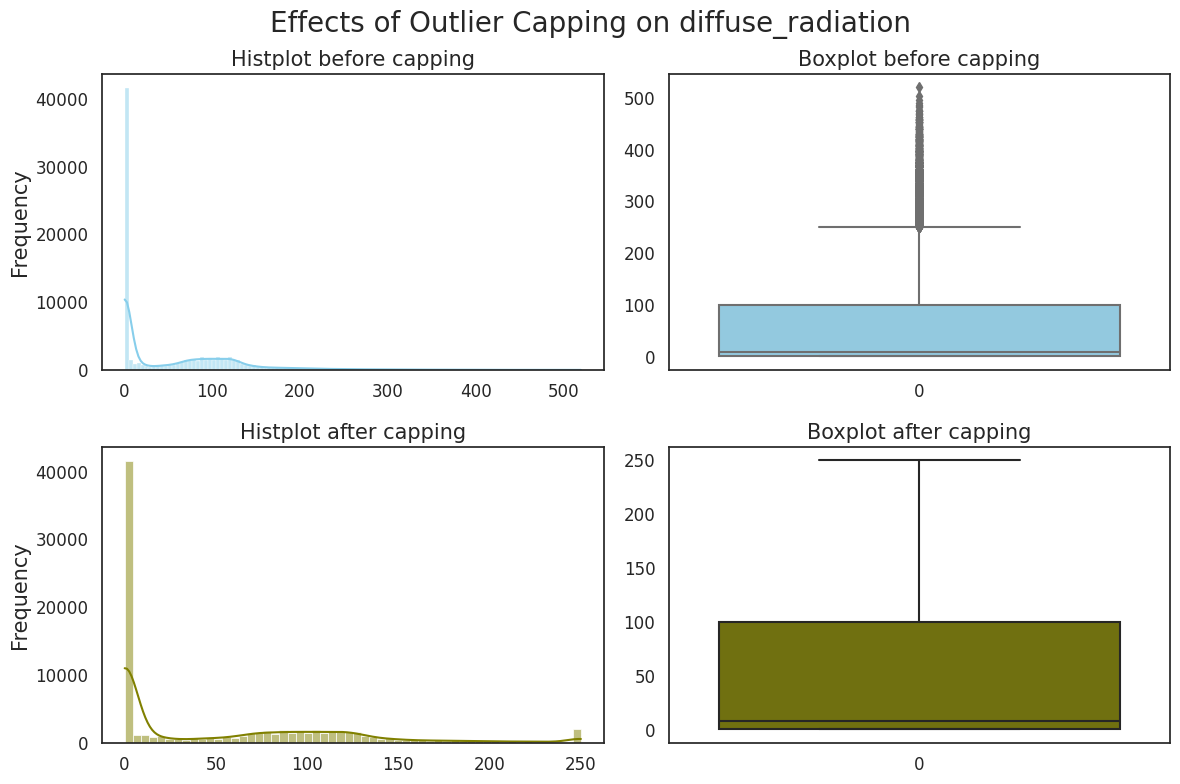

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column windspeed_10m: 955


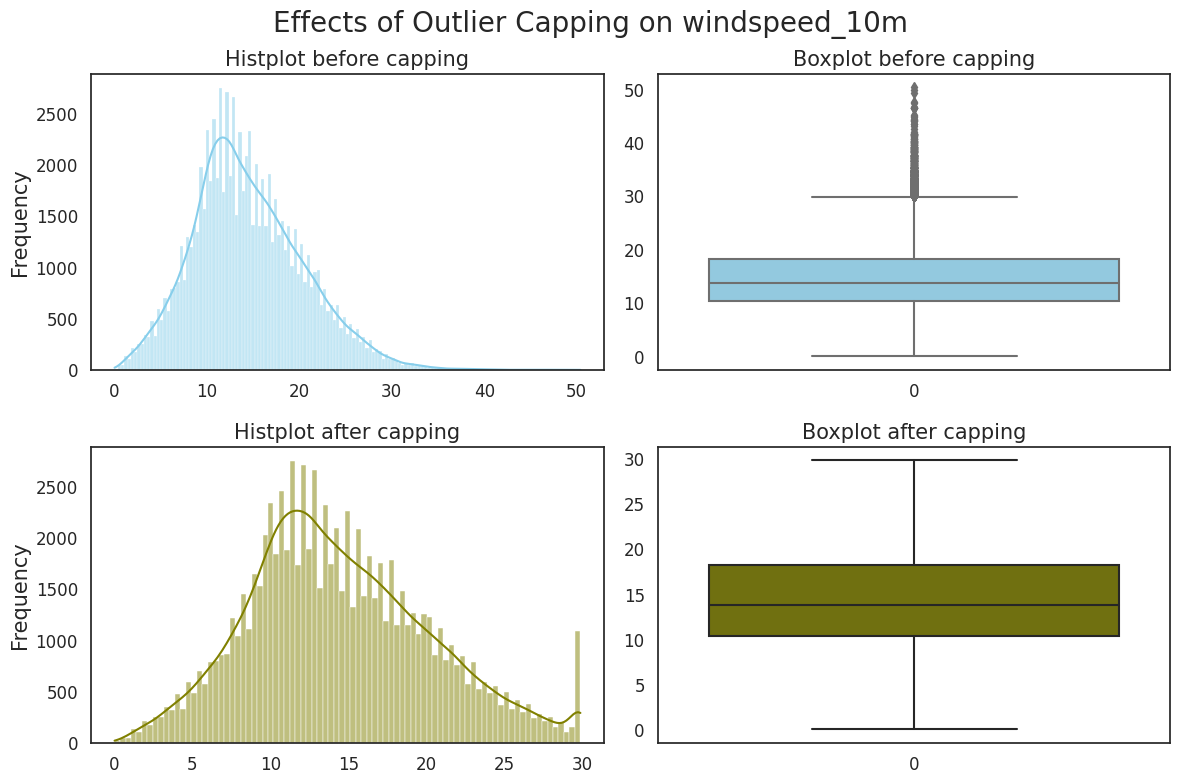

/home/codespace/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The number of values replaced in column cloudcover: 6232


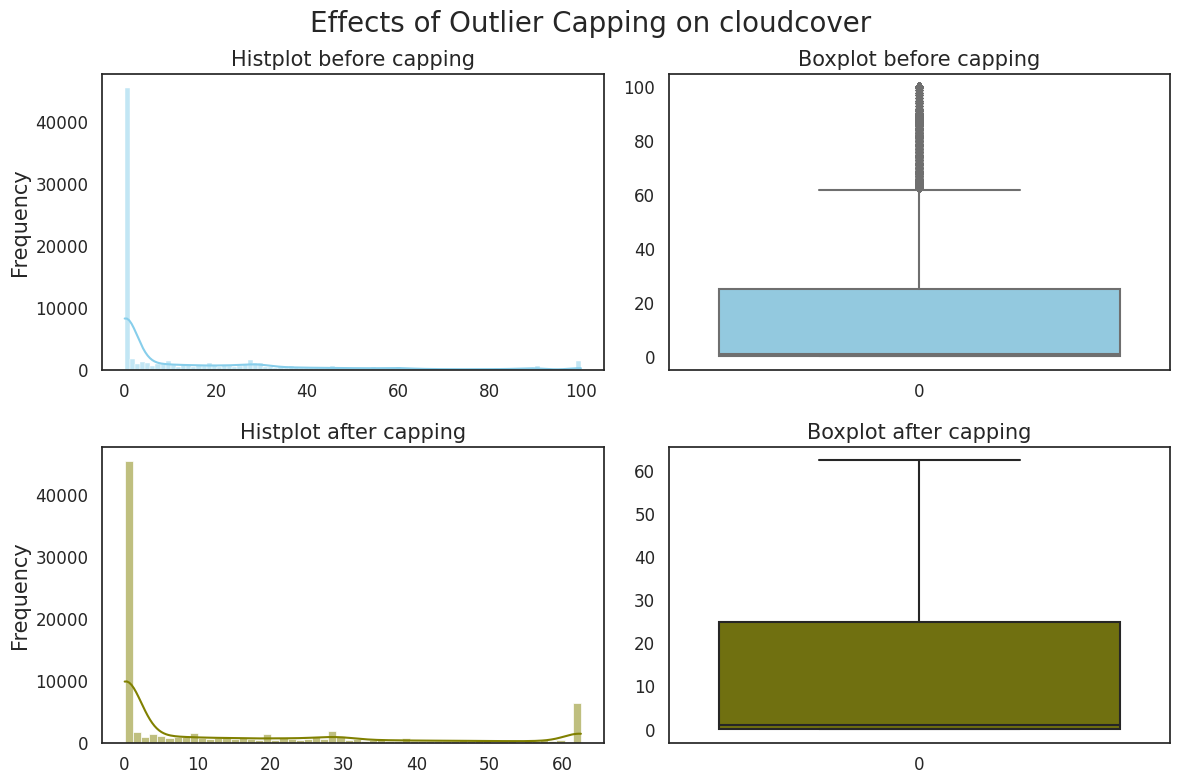

In [14]:

	
sns.set(style='white',palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 5]})

#the following function will clean the data of outliers by using capping, if they exist, and plot the histogram and boxplot before and after
def cap_outliers(df):
    #normal distribution: The data points which fall below mean-3*(sigma) or above mean+3*(sigma) are outliers; 
    #skewed distribution: The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

    new_df_cap = df.copy()
    for col in new_df_cap.columns:
        varcheck = check_gaussian_distribution(df, col, 0.05)
        if varcheck == "Not Gaussian":   
            percentile25 = df[col].quantile(0.25)
            percentile75 = df[col].quantile(0.75)
            IQR = percentile75 - percentile25

            upper_limit = percentile75 + 1.5 * IQR
            lower_limit = percentile25 - 1.5 * IQR
            

            old_values = new_df_cap[col].copy()
            new_df_cap[col] = np.where(
                new_df_cap[col] > upper_limit,
                upper_limit,
                np.where(
                    new_df_cap[col] < lower_limit,
                    lower_limit,
                    new_df_cap[col]
                        )
                )
                # Count the number of values that were replaced
            count = np.sum(old_values != new_df_cap[col])

            print(f"The number of values replaced in column {col}: {count}")
        else:  #if the variable follows a normal distribution
            upper_limit = new_df_cap[col].mean() + 3*df[col].std()
            lower_limit = new_df_cap[col].mean() - 3*df[col].std()
            new_df_cap[col] = np.where(
                new_df_cap[col]>upper_limit,
                upper_limit,
                np.where(
                    new_df_cap[col]<lower_limit,
                    lower_limit,
                    new_df_cap[col]
                        )
                )
            



        plt.figure(figsize=(12,8))

        plt.suptitle('Effects of Outlier Capping on ' + str(col), fontsize=20)

        plt.subplot(2,2,1)
        sns.histplot(df[col], color="skyblue", kde=True).set(xlabel=None)
        plt.title('Histplot before capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        

        plt.subplot(2,2,2)
        sns.boxplot(df[col], color="skyblue")
        plt.title('Boxplot before capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        

        plt.subplot(2,2,3)
        sns.histplot(new_df_cap[col], color="olive", kde=True).set(xlabel=None)
        plt.title('Histplot after capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        

        plt.subplot(2,2,4)
        sns.boxplot(new_df_cap[col], color="olive")
        plt.title('Boxplot after capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        

        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()





    return new_df_cap

transformed_df = cap_outliers(imputed_data_df)

Saving the dataframe with missing values imputed and outliers capped

In [15]:
transformed_df.to_csv('SunPower_Full.csv', sep = ',')

Post-Processing Analysis

In [17]:
full_df = pd.read_csv('SunPower_Full.csv', sep = ',', parse_dates=['timestamp'], index_col='timestamp')

full_df.head()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
timestamp,,,,,,,
2013-07-22 00:00:00,0.000,6.700,67.000,0.000,0.000,10.200,0.000
2013-07-22 01:00:00,0.000,5.700,71.000,0.000,0.000,9.200,0.000
2013-07-22 02:00:00,0.000,4.800,76.000,0.000,0.000,9.100,0.000
2013-07-22 03:00:00,0.000,4.100,79.000,0.000,0.000,10.200,0.000
2013-07-22 04:00:00,0.000,3.400,81.000,0.000,0.000,10.200,0.000


In [18]:
full_df.describe()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
count,85384.000,85384.000,85384.000,85384.000,85384.000,85384.000,85384.000
mean,1.242,22.681,35.014,198.269,53.250,14.459,14.013
std,1.682,8.644,20.983,283.371,66.959,5.866,20.513
min,0.000,-0.600,3.000,0.000,0.000,0.000,0.000
25%,0.000,16.400,19.000,0.000,0.000,10.400,0.000
50%,0.000,23.000,29.000,3.000,8.000,13.800,1.000
75%,2.638,29.100,47.000,387.000,100.000,18.200,25.000
max,5.995,45.100,89.000,967.500,250.000,29.900,62.500


Multicollinearity

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X, thresh=5.0):
    """
    This function calculates the Variance Inflation Factor (VIF) for each feature in a dataframe. 
    It returns a dataframe with the VIF values.
    """
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

def highlight_VIF(series):
    """ 
    This functions highlights VIF values over 10 in red, between 5 and 10 in yellow, and under 5 in green.
    """
    green = 'color: lightgreen'
    yellow = 'color: yellow'
    red = 'color: red'
    return [green if value <= 5 else yellow if value <10 else red for value in series]

VIF_Predictors = ['temperature_2m', 
                  'relativehumidity_2m', 
                  'cloudcover',
                  'direct_radiation', 
                  'diffuse_radiation',
                  'windspeed_10m']


vif_table = calculate_vif(df[VIF_Predictors]).style.apply(highlight_VIF, subset=['VIF'])

vif_table

,feature,VIF
0,temperature_2m,6.511044
1,relativehumidity_2m,2.880960
2,cloudcover,2.064809
3,direct_radiation,3.527919
4,diffuse_radiation,3.594497
5,windspeed_10m,6.270596


Correlation matrix

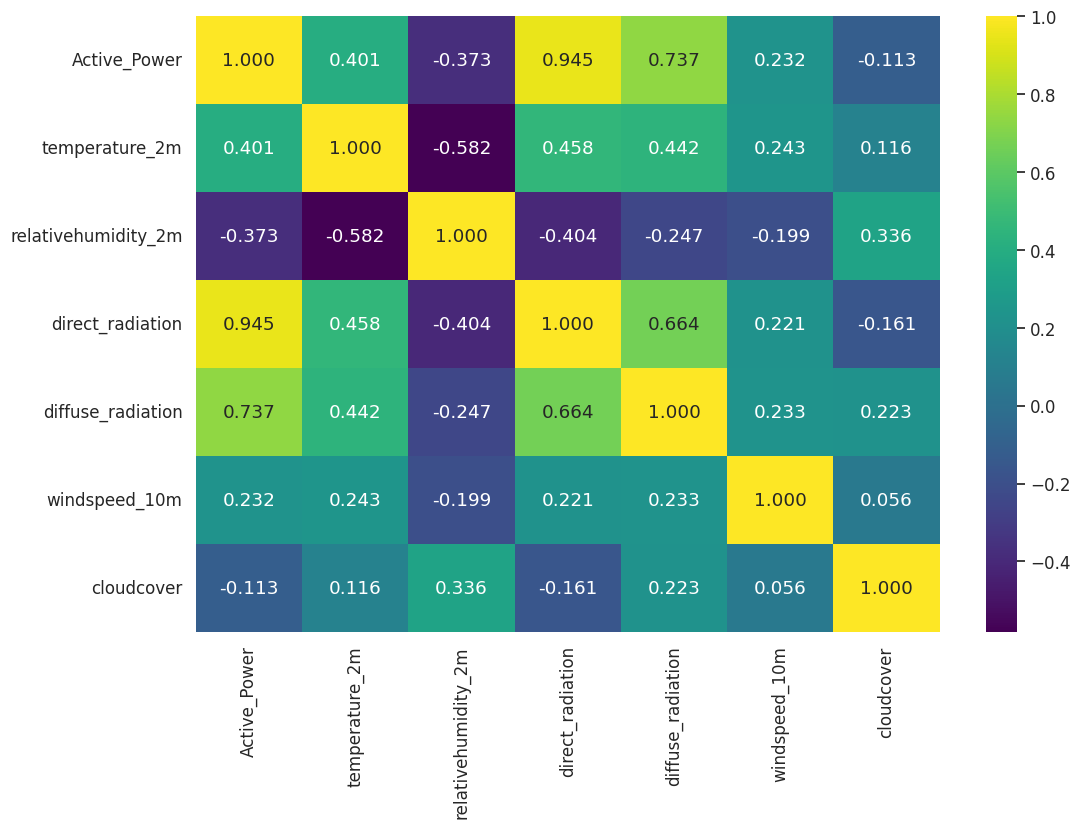

In [20]:
corr = df.corr()
fig,ax = plt.subplots(figsize = (12,8))
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.3f')
plt.show()
